# Covid-19 Forecasting - LSTM

Neste último notebook vamos tentar utilizar os países semelhantes a Portugal para prever os novos casos confirmados por milhão, assim como os novos óbitos por milhão, também iremos prever a tendência de 1 semana para os confirmados e de 2 semanas para os obitos, abordando o problema numa perspetiva de multitasking, tentando prever diferentes séries temporais. Neste caso vamos utilizar uma LSTM para tentar obter os resultados pretendidos.

In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf

In [2]:
kaggle_data_path = "../input/aa2-covid-19-parte-iii"

dataset = pd.read_csv( kaggle_data_path + "/portugal_group_dataset.csv")
dataset = dataset.drop(['Unnamed: 0'], axis = 1)

## Time Shifting

Agora como vamos usar redes LSTM podemos definir que para prever os nossos targets utilizemos mais dias do que o dia anterior.

In [3]:
#Coloca o dataset colocado no argumento no formato indicado para alimentar a LSTM com os valores de dias anteriores.
def time_shift(dataset, step):

    x = []
    y = []

    for day in range(len(dataset)):

        if((day + step + 1) > len(dataset)):
            break

        x.append(dataset[day: (day + step)])
        y.append(dataset[day + step][0:4])

    return np.asarray(x),np.asarray(y).reshape(len(y),-1)

In [4]:
# Cálculo de tendências
def trend_calc(data, step, column):
    trend_column = column + "_trend_" + str(step+1)
    data[trend_column] = (data[column].shift(0, fill_value=0) - data[column].shift(step, fill_value=0))/data[column].shift(step, fill_value=0)
    return data

Agora teremos de efetuar tratamento de dados em todos os países e separando-os para que possamos ter vários inputs. Este tratamento inclui o cálculo das tendências a prever, normalização e os time shifts.

In [5]:
countries = dataset['location'].unique()
X = {}
Y = {}

for country in countries:
    data = dataset[dataset['location'] == country].drop(['location'], axis=1).reset_index(drop=True)
    data = trend_calc(data, 13, 'new_deaths_per_million')
    data = trend_calc(data, 6, 'new_cases_per_million')
    data.replace([np.inf, np.nan], 0, inplace=True)

    mean = data.mean(axis=0)
    std = data.std(axis=0)

    aux = data - mean
    data_normalized = aux / std
    
    x,y=time_shift(data_normalized.to_numpy(), 7)
    
    # X atributos de cada país
    # Y targets de cada país
    X[country] = x
    Y[country] = y

## Splitting the data , 10% test, 10% validation

Embora para os métodos tradicionais tenhamos usado TimeSeriesSplit para este tipo de métodos não vamos conseguir utilizar, muito por falta de tempo para realizar uma otimização do modelo através de cross-validation, por isso vamos apenas partir em percetagens fixas do dataset, apenas para termos uma ideia geral da performance do modelo e da quantidade de overfit.

In [6]:
def split_for_model(data, count):
    x1 = data[:count] 
    x2 = data[count:]
    
    return x1, x2

In [7]:
from sklearn.model_selection import train_test_split

# Função que parte o dataset em treino, teste e validação, com as percetagens pretendidas e agrega 
# todos os datasets nas estruturas correspondestes

def split_data(X,Y,country):
    
    X_val = {}
    Y_val = {}
    X_test = {}
    Y_test = {}
    
    for key in X.keys():
    
        train_count = math.floor(X[key].shape[0] * 0.8)
        val_count =  math.floor((X[key].shape[0] - train_count) / 2)
        
        x_train, x_remainder = split_for_model(X[key], train_count)
        y_train, y_remainder = split_for_model(Y[key], train_count)

        x_val, x_test = split_for_model(x_remainder, val_count)
        y_val, y_test = split_for_model(y_remainder, val_count)

        X[key] = x_train
        Y[key] = y_train
        X_val[key] = x_val
        X_test[key] = x_test
        Y_val[key] = y_val
        Y_test[key] = y_test
         
        if(key == country):
            print("Train set have a shape of " + str(x_train.shape))
            print("Train label have a shape of " + str(y_train.shape))
            print("Dataset shape\n")
            print("Val set have a shape of " + str(x_val.shape))
            print("Val label have a shape of " + str(y_val.shape))
            print("\n")
            print("Test set have a shape of " + str(x_test.shape))
            print("Test label have a shape of " + str(y_test.shape))
        
    return X_val,X_test,Y_val,Y_test,X,Y

X_val,X_test,Y_val,Y_test,X,Y = split_data(X,Y,"Portugal")

Train set have a shape of (74, 7, 4)
Train label have a shape of (74, 4)
Dataset shape

Val set have a shape of (9, 7, 4)
Val label have a shape of (9, 4)


Test set have a shape of (10, 7, 4)
Test label have a shape of (10, 4)


In [8]:
from keras.models import Input,Model, Sequential
from keras.layers import LSTM,Dense,BatchNormalization,concatenate, Dropout
from keras.metrics import RootMeanSquaredError

Using TensorFlow backend.


In [9]:
# function to plot rmse train and validation values
import matplotlib.pyplot as plt
def show_history(history):
    print(history.history.keys())
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Utilizar os vários inputs para formar várias redes

Vamos primeiro tentar utilizar os vários países como diferentes inputs para redes distintas e depois concatenar essas redes.

De seguida vamos construir um modelo através da API funcional do Keras. Iremos criar vários inputs, tendo cada um deles um dataset diferente e que corresponde a cada país. A cada input será associado um modelo de LSTM com recurrent dropout e dropout normal. Depois cada modelo será concatenato e fornecerão entradas a uma rede Dense com ativação relu de seguida uma camada de dropout. Por fim, temos uma camada Dense para o output, tendo ela quatro nodos (4 targets), esta camada não terá ativação, como é habitual para problemas de regressão.

In [10]:
def build_model(X,Y,country_to_predict):
    
    model_inputs = []
    models_lstms = []
    
    for key in X.keys():
      
        x = X[key]
            
        input_ = Input(shape=(x.shape[1],x.shape[2]))
        model_inputs.append(input_)
        
        model = LSTM(units = 64, dropout=0.3, recurrent_dropout=0.3)(input_)
        models_lstms.append(model)
        
    concaten = concatenate(models_lstms,axis = -1)
    
    dens = Dense(32,activation="relu")(concaten)
    drop = Dropout(0.3)(dens)
    answer = Dense(4)(drop)
    
    model = Model(model_inputs, answer)
    
    return model

model = build_model(X,Y,"Portugal")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 7, 4)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7, 4)]       0                                            
______________________________________________________________________________________________

In [11]:
model.compile(optimizer = "rmsprop", loss = "mse", metrics = [RootMeanSquaredError()])

Colocar os países como listas para treinar o modelo.

In [12]:
X_test_list = list(X_test.values())
Y_test_list = list(Y_test.values())
X_val_list = list(X_val.values())
Y_val_list = list(Y_val.values())
X_train_list = list(X.values())
Y_train_list = list(Y.values())

print(len(X_train_list),X_train_list[0].shape,Y["Portugal"].shape)

18 (74, 7, 4) (74, 4)


Para o treino do modelo temos de fornecer todos os dados relativos aos conjuntos de treino de todos os países. Na verdade no fim conseguiremos prever não só as séries temporais de Portugal como dos outros países que se encontram no grupo.

In [13]:
history = model.fit(X_train_list,Y_train_list,epochs=75,validation_data=(X_val_list,Y_val_list),verbose=2)

Epoch 1/75
3/3 - 5s - loss: 1.0304 - root_mean_squared_error: 1.0151 - val_loss: 0.8066 - val_root_mean_squared_error: 0.8981
Epoch 2/75
3/3 - 1s - loss: 0.7777 - root_mean_squared_error: 0.8819 - val_loss: 0.7459 - val_root_mean_squared_error: 0.8637
Epoch 3/75
3/3 - 1s - loss: 0.7397 - root_mean_squared_error: 0.8601 - val_loss: 0.7579 - val_root_mean_squared_error: 0.8705
Epoch 4/75
3/3 - 1s - loss: 0.6301 - root_mean_squared_error: 0.7938 - val_loss: 0.7357 - val_root_mean_squared_error: 0.8577
Epoch 5/75
3/3 - 1s - loss: 0.6007 - root_mean_squared_error: 0.7751 - val_loss: 0.7521 - val_root_mean_squared_error: 0.8672
Epoch 6/75
3/3 - 1s - loss: 0.5642 - root_mean_squared_error: 0.7511 - val_loss: 0.7767 - val_root_mean_squared_error: 0.8813
Epoch 7/75
3/3 - 1s - loss: 0.6562 - root_mean_squared_error: 0.8101 - val_loss: 0.7798 - val_root_mean_squared_error: 0.8830
Epoch 8/75
3/3 - 1s - loss: 0.5981 - root_mean_squared_error: 0.7734 - val_loss: 0.8118 - val_root_mean_squared_error:

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


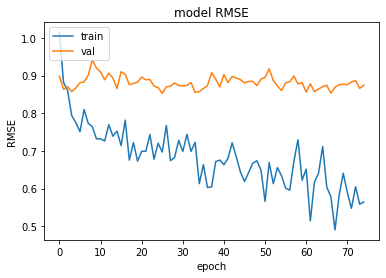

In [14]:
show_history(history)

Pelo gráfico anterior conseguimos ver que existe overfiting, o que era de esperar, visto que continuamos a ter muito poucos dados, mesmo usando dropout. O erro na validação está sempre maior do que o do de treino daí o overfit.

Vejamos então como se comporta o modelo, quando fornecidas as séries temporais de todos os países do conjunto de teste.

In [15]:
model.evaluate(X_test_list, Y_test['Portugal'])

1/1 [==============================] - 0s 2ms/step - loss: 0.1205 - root_mean_squared_error: 0.3472


[0.12054324150085449, 0.3471933901309967]

In [16]:
predictions = model.predict(X_test_list)

Podemos ver abaixo os RMSE indivudais para a comparação entre previsões e dados reais de Portugal. Conseguimos concluir que para os novos casos e mortes os resultados foram razoáveis, mas não melhores do que os com métodos tradicionais, muito pelo facto de não termos o modelo otimizado, estando otimizado concerteza que iam ser melhores, mas também temos de ter em conta que estamos agora a prever para muitos países o que é de facto uma vantagem.  

In [17]:
from sklearn.metrics import mean_squared_error

print("RMSE new_cases: ",np.sqrt(mean_squared_error(Y_test['Portugal'][:,0],predictions[:,0])) * std[0] + mean[0])
print("RMSE new_deaths: ",np.sqrt(mean_squared_error(Y_test['Portugal'][:,1],predictions[:,1])) * std[1] + mean[1])
print("RMSE cases_trend: ",np.sqrt(mean_squared_error(Y_test['Portugal'][:,2],predictions[:,2])) * std[2] + mean[2])
print("RMSE deaths_trend ",np.sqrt(mean_squared_error(Y_test['Portugal'][:,3],predictions[:,3])) * std[3] + mean[3])

RMSE new_cases:  49.52478285787273
RMSE new_deaths:  8.917170575457442
RMSE cases_trend:  6.52827898386294
RMSE deaths_trend  0.6664391396757653


Apenas para termo de comparação temos os resultado relativos a um país dentro do grupo a França. Os resultado foram bastante semelhantes o que vai de encontro ao que estávamos à espera, pelo facto de pertencerem a grupos com séries temporais semelhantes

In [18]:
from sklearn.metrics import mean_squared_error

print("RMSE new_cases: ",np.sqrt(mean_squared_error(Y_test['France'][:,0],predictions[:,0])) * std[0] + mean[0])
print("RMSE new_deaths: ",np.sqrt(mean_squared_error(Y_test['France'][:,1],predictions[:,1])) * std[1] + mean[1])
print("RMSE cases_trend: ",np.sqrt(mean_squared_error(Y_test['France'][:,2],predictions[:,2])) * std[2] + mean[2])
print("RMSE deaths_trend ",np.sqrt(mean_squared_error(Y_test['France'][:,3],predictions[:,3])) * std[3] + mean[3])

RMSE new_cases:  57.46834515129597
RMSE new_deaths:  7.16613164555322
RMSE cases_trend:  6.351676099884737
RMSE deaths_trend  0.6715461273028813


In [19]:
def bar_plot(index, country, title):
    x1_draw = Y_test[country][:,index] * std[index] + mean[index]
    x2_draw = predictions[:,index] * std[index] + mean[index]
    r = pd.DataFrame({'Real':x1_draw, 'Predicted': x2_draw})
    r.plot(kind='bar',figsize=(20,5), title='Predictions for ' + title)
    plt.show()

Podemos agora ver os resultados previstos em comparação com os dados de teste, para todas as variáveis alvo de uma forma mais visual.

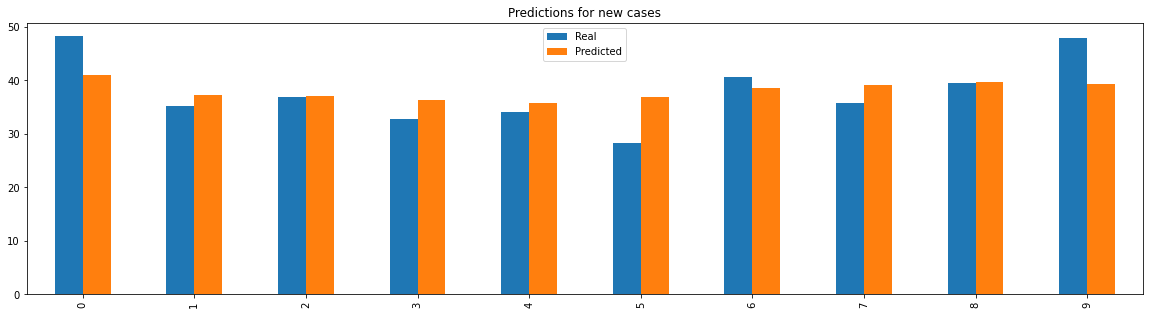

In [20]:
bar_plot(0, 'Portugal', 'new cases')

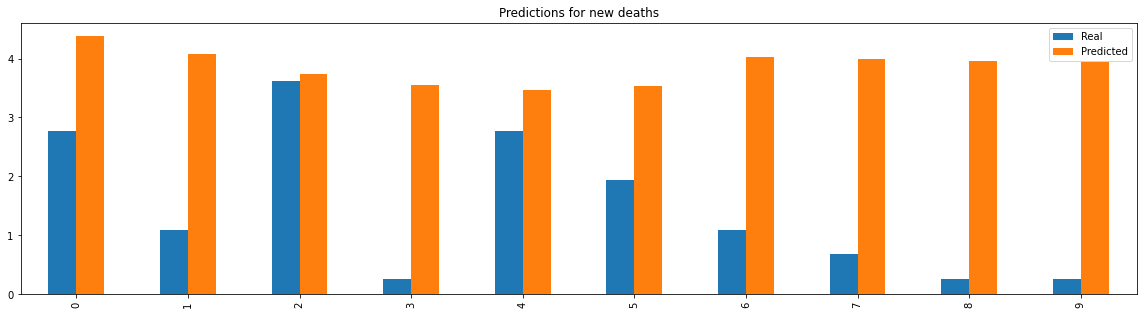

In [21]:
bar_plot(1, 'Portugal', 'new deaths')

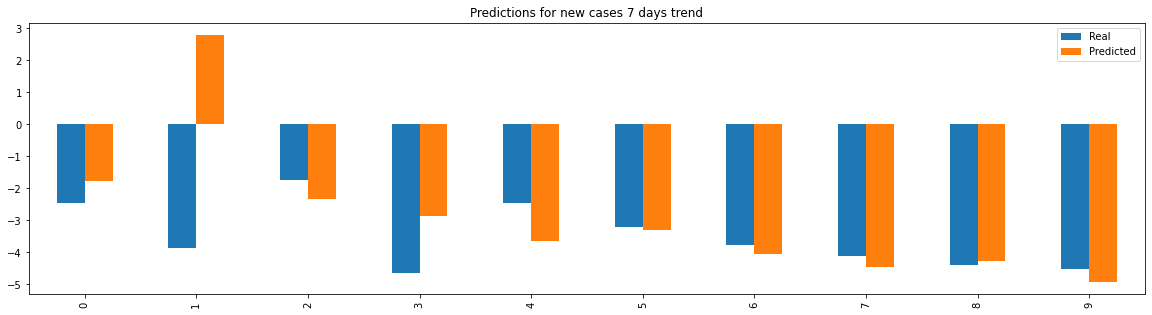

In [22]:
bar_plot(2, 'Portugal', 'new cases 7 days trend')

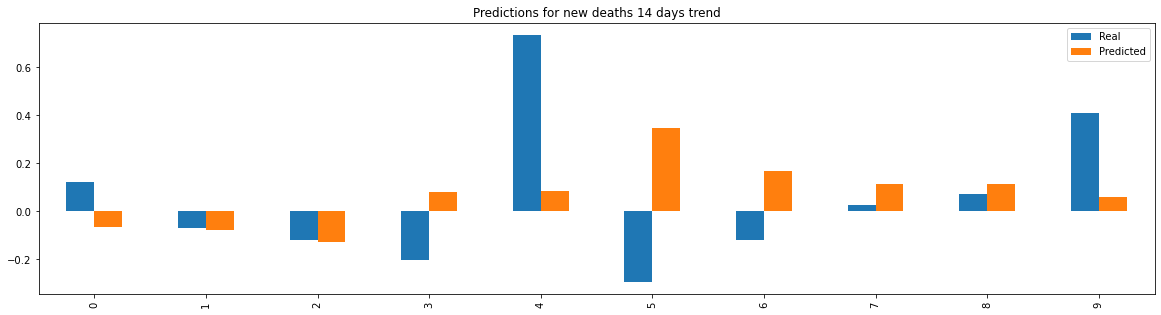

In [23]:
bar_plot(3, 'Portugal', 'new deaths 14 days trend')

Outra solução sem utilizar vários inputs seria treinar o modelo várias vezes e usar para cada conjunto distinto de epochs diferentes países. Na verdade isso era algo simples de fazer, ficando aqui abaixo o código, mas é complicado de analisar a evolução do modelo, porque cada fit gera um history diferente

In [24]:
input_ = Input(shape=(7,4))
model = LSTM(64, input_shape=(7,4), dropout=0.3, recurrent_dropout=0.3)(input_)
model = Dense(32,activation="relu")(model)
answer = Dense(4)(model)
model = Model([input_], [answer])
model.compile(optimizer = "rmsprop", loss = "mse", metrics = [RootMeanSquaredError()])

for country in dataset['location'].unique():
    history = model.fit(X[country],Y[country],epochs=2,validation_data=(X_val[country],Y_val[country]),shuffle= False,verbose=2)

## Conclusão

Infelizmente não conseguimos otimizar o nosso modelo de DL quer ao nível do hiperparâmetros quer ao nível da arquitetura que certamente terá muitas desvantagens, porém conseguimos rapidamente constatar que caso houvesse otimização este tipo de modelos rapidamente ultrapassam os de ML clássico, especialmete quando existem muitos dados, o que infelizmente nunca foi o caso. Este tipo de modelo ganhou bastante em comparação com os de ML clássico em termos de flexibilidade, não havendo necessidade de criar vários modelos para cada output.